In [49]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
import json
import pandas as pd
import numpy as np
import seaborn as sns
import math
import skimage.measure

In [50]:
def getSecondFromTimeStamp(timestamp):
    return timestamp["hour"]*60*60 + timestamp["minute"]*60 + timestamp["seconds"]

# Load gaze session

In [51]:
session_path = "saved_sessions/session_2021-09-10T08:10:40.400005/session_2021-09-10T08:10:40.400005.json"
with open(session_path, "r") as f:
    session_arr = json.load(f)
# session_arr

In [52]:
start_time = -1
end_time = -1

for session in session_arr:
    gaze_arr = session_arr[session]
    print("{} >> {} gaze points".format(session, len(gaze_arr)))

    if(start_time == -1):
        start_time = getSecondFromTimeStamp(gaze_arr[0]['timestamp'])
    else:
        start_time = min(getSecondFromTimeStamp(gaze_arr[0]['timestamp']), start_time)

    if(end_time == -1):
        end_time = getSecondFromTimeStamp(gaze_arr[-1]["timestamp"])
    else:
        end_time = max(getSecondFromTimeStamp(gaze_arr[-1]["timestamp"]), end_time)


print(start_time, " --> ", end_time)

cuh3bmjs2zo9wvzdbzsk6d >> 2359 gaze points
mhhaau1ln9bkyrneluj1m >> 9687 gaze points
65127  -->  65437


In [53]:
def filterBySeconds__session(frm, to, session_arr = session_arr):
    filter = {}
    for session in session_arr:
        filter[session] = []
        gaze_arr = session_arr[session]
        for gaze in gaze_arr:
            timestamp = getSecondFromTimeStamp(gaze["timestamp"])
            if(timestamp < frm):
                continue
            if(timestamp > to):
                break
            filter[session].append(gaze)
    return filter

# Visualize session

In [54]:
def processOneSession(gaze_arr):
    xrr = []
    yrr = []
    for gaze in gaze_arr:
        xrr.append(gaze["gaze"]["x"])
        yrr.append(gaze["gaze"]["y"])
    return np.array(xrr), np.array(yrr)

In [59]:
def plotSession(session_arr):
    for session in session_arr:
        xrr, yrr = processOneSession(session_arr[session])
        print(type(xrr), xrr.shape)
        print(type(yrr), yrr.shape)

        plt.scatter(xrr, yrr, label = "{}".format(session))

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.gca().invert_yaxis()

    return plt

<class 'numpy.ndarray'> (2359,)
<class 'numpy.ndarray'> (2359,)
<class 'numpy.ndarray'> (9687,)
<class 'numpy.ndarray'> (9687,)


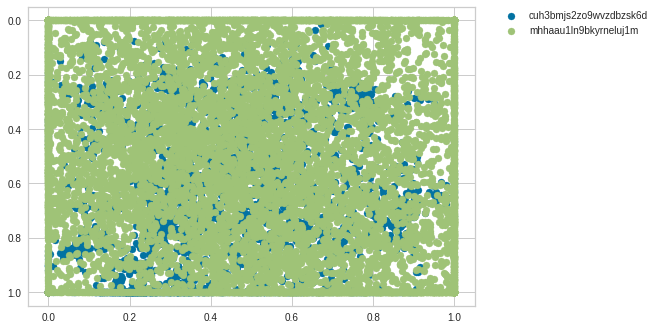

In [60]:
plot = plotSession(session_arr)

65127 65437 65127
>>>  From 65127 to 65137
session cuh3bmjs2zo9wvzdbzsk6d -> 83 gaze points
session mhhaau1ln9bkyrneluj1m -> 191 gaze points
>>>  From 65137 to 65147
session cuh3bmjs2zo9wvzdbzsk6d -> 80 gaze points
session mhhaau1ln9bkyrneluj1m -> 357 gaze points
>>>  From 65147 to 65157
session cuh3bmjs2zo9wvzdbzsk6d -> 89 gaze points
session mhhaau1ln9bkyrneluj1m -> 360 gaze points


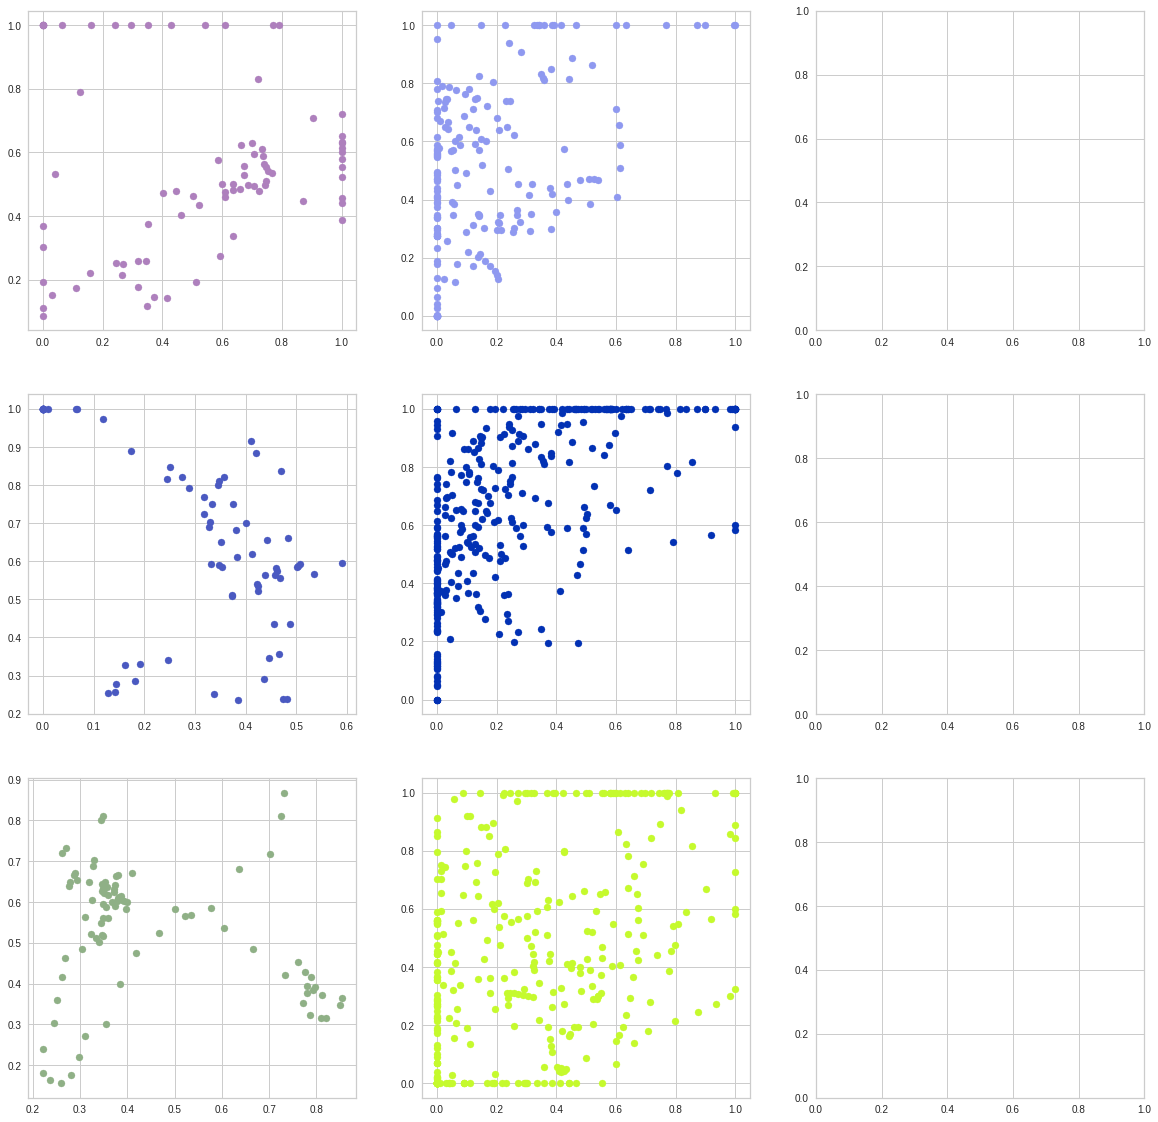

In [67]:
###########################################################################
limiter = 3
num_person = 2
frm = start_time
time_gap = 10
##########################################################################
print(start_time, end_time, frm)

col_fix = num_person+1
col_width = 20

plt.rcParams["figure.figsize"] = (col_width, col_width*limiter/3)
fig, ax = plt.subplots(nrows=limiter, ncols=col_fix)

counter = 0


while(frm < end_time):
    if(counter == limiter):
        break
    to = frm + time_gap

    cur_session = filterBySeconds__session(frm, to)
    print(">>>  From {} to {}".format(frm, to))

    col = 0
    
    for session in cur_session:
        print("session {} -> {} gaze points".format(session, len(cur_session[session])))
        sb_plot = ax[counter, col]
        xrr, yrr = processOneSession(cur_session[session])
        sb_plot.scatter(xrr, yrr, color=np.random.rand(3,))
        col += 1

    frm = to
    counter += 1

1 4
loaded user_1/bottom_left.json >> (85, 2)
loaded user_2/bottom_right.json >> (85, 2)
loaded user_3/upper_right.json >> (84, 2)
loaded user_4/upper_left.json >> (88, 2)
 >>>> Loaded dataset >>>  (342, 2)


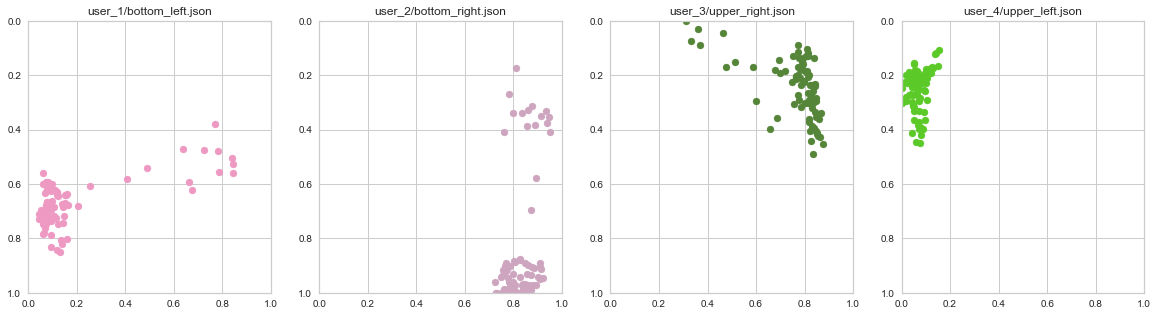

In [23]:
X = None

col_fix = 4
row_fix = np.math.ceil(len(path_arr)/col_fix)
col_width = 20

print(row_fix, col_fix)

plt.rcParams["figure.figsize"] = (20,row_fix*col_width//col_fix)
fig, ax = plt.subplots(nrows=row_fix, ncols=col_fix)

row = 0
col = 0
for path in path_arr:
    x_cur = loadGazeSession_session(path)
    if(X is not None):
        X = np.concatenate((X, x_cur), axis=0)
    else:
        X = x_cur

    if(row_fix > 1):
        sb_plot = ax[row, col]
    else:
        sb_plot = ax[col]
    sb_plot.scatter(x=x_cur[:, 0], y=x_cur[:, 1], color=np.random.rand(3,))
    sb_plot.set_xlim([0,1])
    sb_plot.set_ylim([0,1])
    sb_plot.invert_yaxis()
    sb_plot.title.set_text(path)
    col += 1
    if(col == col_fix):
        row += 1
        col = 0

print(" >>>> Loaded dataset >>> ", X.shape)

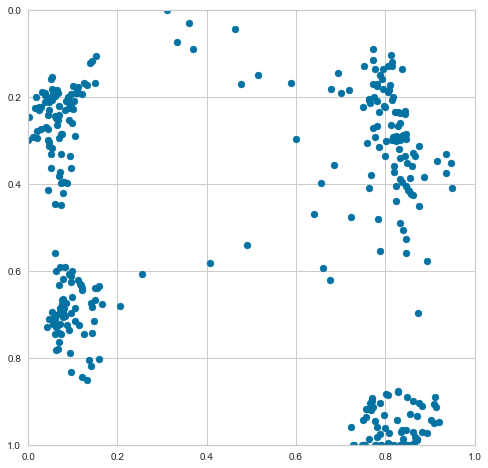

In [39]:
plt.rcParams["figure.figsize"] = (8, 8)

plt.scatter(X[:, 0], X[:, 1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.gca().invert_yaxis()

In [40]:
heat_map = np.zeros((1001, 1001))

for point in X:
    col = int(point[0]*1000)
    row = int(point[1]*1000)
    heat_map[row, col] += 1

heat_map.shape

(1001, 1001)

In [41]:
heatmap_reduced = skimage.measure.block_reduce(heat_map, (100,100), np.mean)
print(heatmap_reduced.shape)
print(heatmap_reduced)

(11, 11)
[[0.     0.     0.     0.0004 0.0001 0.     0.     0.0001 0.     0.
  0.    ]
 [0.0014 0.0012 0.     0.     0.0001 0.0002 0.0002 0.0012 0.0008 0.
  0.    ]
 [0.004  0.0003 0.     0.     0.     0.     0.0001 0.0012 0.0016 0.
  0.    ]
 [0.0015 0.     0.     0.     0.     0.     0.0002 0.0004 0.0018 0.0004
  0.    ]
 [0.0004 0.     0.     0.     0.     0.     0.0001 0.0003 0.0009 0.0001
  0.    ]
 [0.0003 0.     0.     0.     0.0002 0.     0.0001 0.0001 0.0004 0.
  0.    ]
 [0.0024 0.0013 0.0002 0.     0.     0.     0.0001 0.     0.0001 0.
  0.    ]
 [0.002  0.0005 0.     0.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0.0001 0.0005 0.     0.     0.     0.     0.     0.0002 0.0006 0.0001
  0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.0015 0.0019 0.0005
  0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.0009 0.0012 0.
  0.    ]]


0.0 0.004


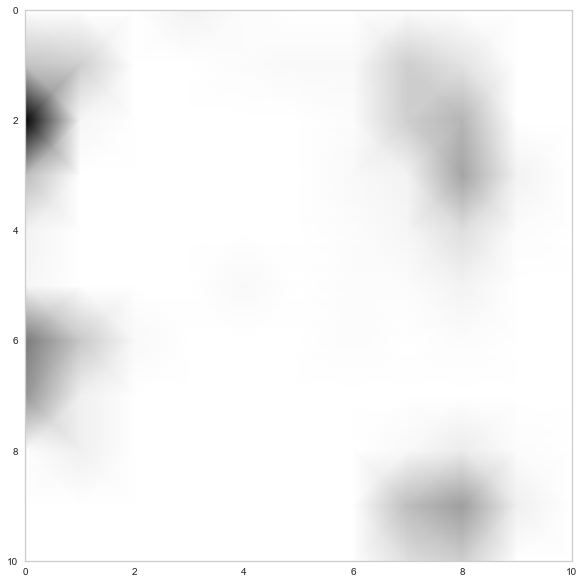

In [128]:
print(heatmap_reduced.min(), heatmap_reduced.max())
fig, ax = plt.subplots(constrained_layout=True)
ax.pcolormesh(np.arange(11), np.arange(11), heatmap_reduced, 
                shading='gouraud', 
                vmin=heatmap_reduced.min(), 
                vmax=heatmap_reduced.max())
ax.invert_yaxis()

# Tuning EPS

(342, 11) (342, 11)


Text(0, 0.5, 'Distance')

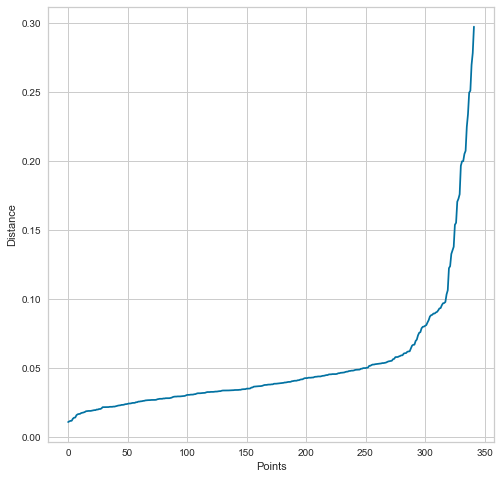

In [43]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
print(distances.shape, indices.shape)
dist = np.sort(distances[:,10])

plt.plot(dist)
plt.xlabel("Points")
plt.ylabel("Distance")

292 0.06983552104767311


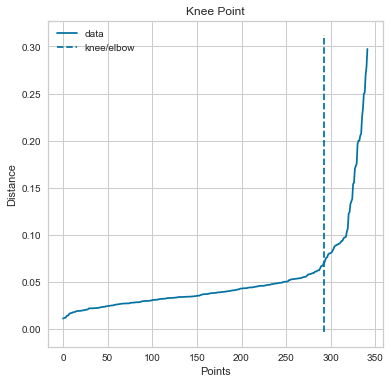

In [44]:
from kneed import KneeLocator
i = np.arange(len(dist))
kneedle = KneeLocator(i, dist, S=1, curve='convex', direction='increasing', interp_method='polynomial')

kneedle.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

knee_val = dist[kneedle.knee]
print(kneedle.knee, knee_val)

In [45]:
# fig = plt.figure(figsize=(20, 10))
# fig.subplots_adjust(hspace=.5, wspace=.2)
# i = 1
# for x in range(10, 0, -1):
#     eps = 1/(11-x)
#     db = DBSCAN(eps=eps, min_samples=10).fit(X)
#     core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#     core_samples_mask[db.core_sample_indices_] = True
#     labels = db.labels_
    
#     print(eps)
#     ax = fig.add_subplot(2, 5, i)
#     ax.text(1, 4, "eps = {}".format(round(eps, 1)), fontsize=25, ha="center")
#     sns.scatterplot(x = X[:,0], y = X[:,1], hue=["cluster-{}".format(x) for x in labels])
    
#     i += 1

# DBSCAN

## limiation: Assumes uniform density among all the clusters

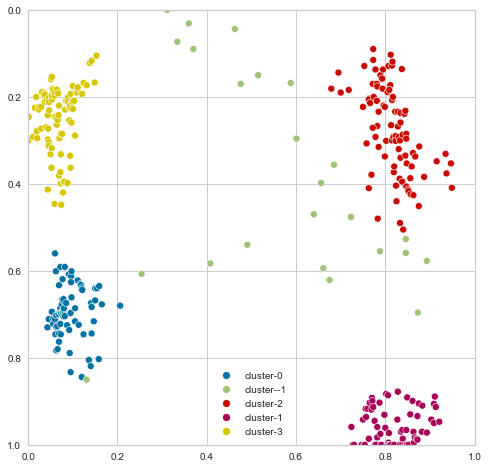

In [97]:
plt.rcParams["figure.figsize"] = (8, 8)

model = DBSCAN(eps=knee_val, min_samples=10).fit(X)
labels = model.labels_

ax = sns.scatterplot(x = X[:,0], y = X[:,1], hue=["cluster-{}".format(x) for x in labels])
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.invert_yaxis()

In [98]:
def point_dist(x1, y1, x2, y2):
    return np.math.sqrt((x2-x1)**2 + (y2-y1)**2)

def getClusterCentroid(points_df):
    return tuple(points_df.mean())

def getIntraClusterDistance(points_df, times=1000):
    sum = 0
    for idx, ipt in points_df.iterrows():
        x1 = ipt["x0"]*times
        y1 = ipt["x1"]*times
        for jdx, jpt in points_df.iterrows():
            x2 = jpt["x0"]*times
            y2 = jpt["x1"]*times
        sum += point_dist(x1, y1, x2, y2)

    intra_dist_times_1000 = sum/(len(points_df)**2)
    return intra_dist_times_1000

def getSingleCluster__attrs(points_df):
    return {
        "num points": len(points_df),
        "center"    : getClusterCentroid(points_df),
        "intra_dist": getIntraClusterDistance(points_df, times=1000)
    }

# points = df[df["pred_y"] == 2][["x0", "x1"]]
# getSingleCluster__attrs(points)

In [47]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters: ", n_clusters_)
for cluster in range(n_clusters_):
    print("cluster {} => number of points: {}".format(cluster, list(labels).count(cluster)))
n_noise_ = list(labels).count(-1)
print("Noise points: ", n_noise_)

Number of clusters:  4
cluster 0 => number of points: 71
cluster 1 => number of points: 69
cluster 2 => number of points: 90
cluster 3 => number of points: 88
Noise points:  24


Number of clusters:  4
Noise      >> number of points: 24; center: (0.5661666666666667, 0.39295833333333324); intra_cluster_dist: 12.437734068752645
Cluster: 0 >> number of points: 71; center: (0.09450704225352118, 0.693943661971831); intra_cluster_dist: 1.7848997692601118
Cluster: 1 >> number of points: 69; center: (0.8185362318840576, 0.9571304347826085); intra_cluster_dist: 1.625489873525587
Cluster: 2 >> number of points: 90; center: (0.8159111111111108, 0.2772333333333334); intra_cluster_dist: 2.1364984961973708
Cluster: 3 >> number of points: 88; center: (0.0688181818181818, 0.24921590909090915); intra_cluster_dist: 1.948611932638227


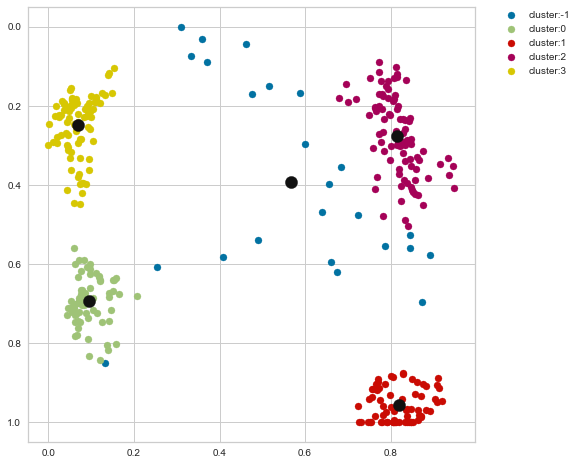

In [129]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters: ", n_clusters_)

df = pd.DataFrame({
    "x0"    : X[:, 0],
    "x1"    : X[:, 1],
    "pred_y": labels
})
centroids = []

description = ""
for cluster in range(-1, n_clusters_):
    points_df = df[df["pred_y"] == cluster][["x0", "x1"]]
    single_cluster_attrs = getSingleCluster__attrs(points_df)
    cluster_name = "Noise     "
    if(cluster != -1):
        cluster_name = "Cluster: {}".format(cluster)
    print("{} >> number of points: {}; center: {}; intra_cluster_dist: {}".format(
        cluster_name, len(points_df), single_cluster_attrs["center"] ,single_cluster_attrs["intra_dist"]))
    description += "{} >> {} points; center: ({},{}); intra_cluster_dist: {}\n".format(
        cluster_name, len(points_df), round(single_cluster_attrs["center"][0]), 
        round(single_cluster_attrs["center"][1],2), round(single_cluster_attrs["intra_dist"], 3))

    centroids.append(single_cluster_attrs["center"])
    plt.scatter(points_df["x0"], points_df["x1"], label = "cluster:{}".format(cluster))

for center in centroids:
    plt.scatter(center[0] , center[1] , s = 150, color = 'k')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.gca().invert_yaxis()

In [125]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print("Silhouette        (higher is better): ", silhouette_score(X, labels))
print("Calinski-Harabasz (higher is better): ", calinski_harabasz_score(X, labels))
print("Davies-Bouldin    (lower is better) : ", davies_bouldin_score(X, labels))

description += "\n\n"
description += json.dumps({
    "Silhouette": silhouette_score(X, labels),
    "Calinski-Harabasz": calinski_harabasz_score(X, labels),
    "Davies-Bouldin": davies_bouldin_score(X, labels)
}, indent=4)

Silhouette        (higher is better):  0.6939332330064207
Calinski-Harabasz (higher is better):  1246.3485878170675
Davies-Bouldin    (lower is better) :  0.9408468739758333


## Mid-Mid == Perfect
Silhouette:  0.5018510861248267 <br>
Calinski-Harabasz:  78.44613796859764 <br>
Davies-Bouldin:  0.900597056080566

In [111]:
description

'Noise      >> 24 points; center: (1,0.39); intra_cluster_dist: 12.438\nCluster: 0 >> 71 points; center: (0,0.69); intra_cluster_dist: 1.785\nCluster: 1 >> 69 points; center: (1,0.96); intra_cluster_dist: 1.625\nCluster: 2 >> 90 points; center: (1,0.28); intra_cluster_dist: 2.136\nCluster: 3 >> 88 points; center: (0,0.25); intra_cluster_dist: 1.949\n'

(0.0, 1.0, 0.0, 1.0)

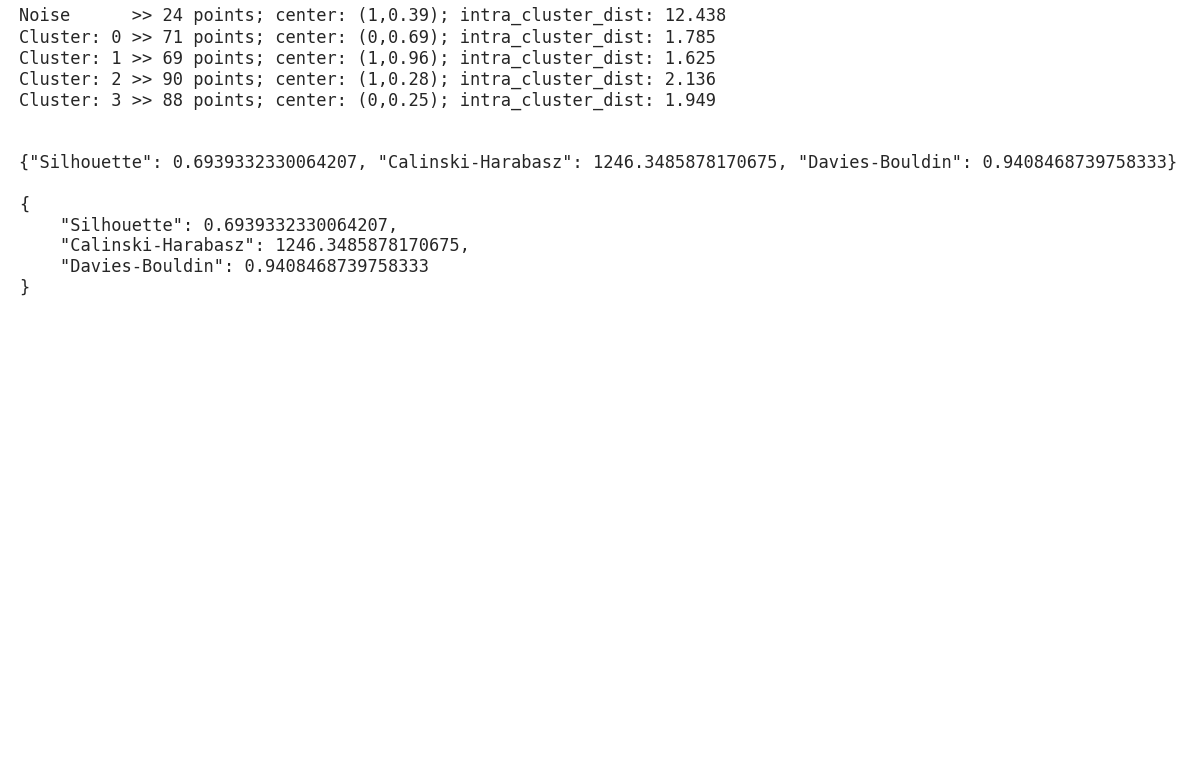

In [126]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.text(0.02,0.8, description, family="monospace", fontsize=17)
ax.axis('off')

In [124]:
description

'Noise      >> 24 points; center: (1,0.39); intra_cluster_dist: 12.438\nCluster: 0 >> 71 points; center: (0,0.69); intra_cluster_dist: 1.785\nCluster: 1 >> 69 points; center: (1,0.96); intra_cluster_dist: 1.625\nCluster: 2 >> 90 points; center: (1,0.28); intra_cluster_dist: 2.136\nCluster: 3 >> 88 points; center: (0,0.25); intra_cluster_dist: 1.949\n\n\n{"Silhouette": 0.6939332330064207, "Calinski-Harabasz": 1246.3485878170675, "Davies-Bouldin": 0.9408468739758333}'